In [1]:
import numpy as np
import random

import pandas as pd
import os
import pickle
import sys
import timeit

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import pickle

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_spd_matrix
from sklearn import tree
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import seaborn as sn

sys.path.append('../')

import random

from thresholds2 import *

## 1. Simulate data

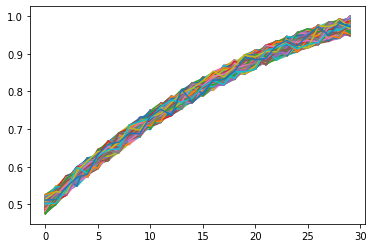

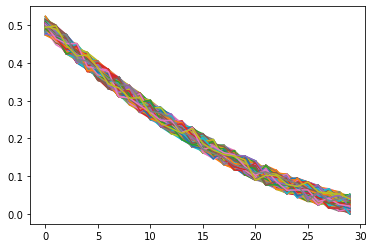

In [2]:
def p_increase(t, T):
    return 1-(t/(T+10)-1)**2

def p_decrease(t, T):
    return (t/(T+10)-1)**2 - 1

def sim_data(I, T):
    theta_base = np.array([[0.1, 0.5], [0.5, 0.9], [0.2, 0.8]])

    p_mean_increase = np.array([0.5 + p_increase(t, T) for t in range(T)])
    p_mean_decrease = np.array([0.5 + p_decrease(t, T) for t in range(T)])
    
    theta_g = random.choices(range(len(theta_base)),k=I)
    p_g = np.array(random.choices(range(2), k = I))

    theta = np.array([theta_base[theta_g[i]] for i in range(I)])
    x = np.array([theta_base[g] + np.random.normal(0, 0.01, 2) for g in theta_g])

    t_Sigma = make_spd_matrix(T)
    t_noise = np.random.multivariate_normal(np.zeros(T), t_Sigma, size=I)
    normalized_noise = []
    for i in range(t_noise.shape[0]):
        tmp = t_noise[i,:]
        if np.min(tmp) < 0:
            tmp -= np.min(tmp)
        normalized_noise.append(tmp *0.1/np.max(tmp))
    normalized_noise = np.array(normalized_noise)

    p = np.array([p_mean_increase if p_g[i] == 0 else p_mean_decrease for i in range(I)])
    p = p + normalized_noise
    p = p - np.min(p)
    p = p/np.max(p)

    y = [(p[i] >= theta[i][1])*1 - (p[i] <= theta[i][0])*1 for i in range(I)]

    plt.plot(np.transpose(p[p_g == 0]))
    plt.show()
    
    plt.plot(np.transpose(p[p_g == 1]))
    plt.show()
    
    return x, p, y, theta

I = 1000
T = 30
x, p, y, theta = sim_data(I, T)

## 2. Split data

In [3]:
X_train_valid, X_test, P_train_valid, P_test, Y_train_valid, Y_test, Theta_train_valid, Theta_test = train_test_split(x,p, y,theta, test_size=0.2)
X_train, X_valid, P_train, P_valid, Y_train, Y_valid, Theta_train, Theta_valid = train_test_split(X_train_valid,P_train_valid, Y_train_valid,Theta_train_valid, test_size=0.2)

X_train, P_train, Y_train, Theta_train = np.array(X_train), np.array(P_train), np.array(Y_train), np.array(Theta_train)
X_valid, P_valid, Y_valid, Theta_valid = np.array(X_valid), np.array(P_valid), np.array(Y_valid), np.array(Theta_valid)
X_test, P_test, Y_test, Theta_test = np.array(X_test), np.array(P_test), np.array(Y_test), np.array(Theta_test)

print(np.sum(Y_train == 1), np.sum(Y_train == 0), np.sum(Y_train == -1))

5909 7748 5543


## 3. Fit costant thresholds

../thresholds2.py:25: RuntimeWarning: invalid value encountered in true_divide
  value /= (s+r)
../thresholds2.py:26: RuntimeWarning: invalid value encountered in true_divide
  value /= (u+v)


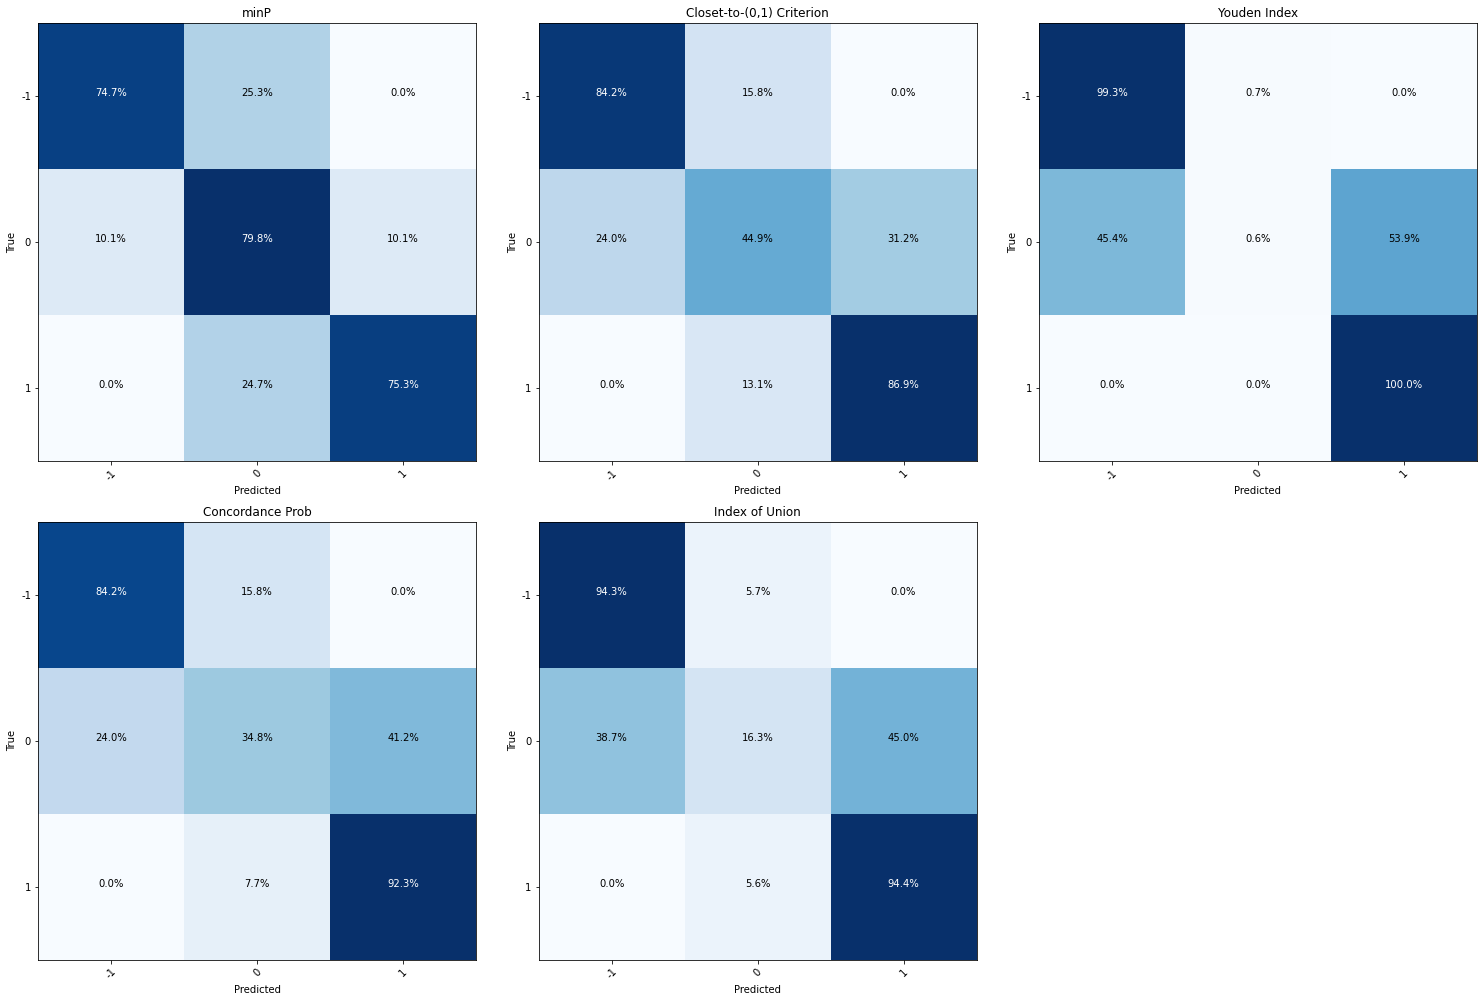

,Method,Cut0,RMSE0,Cut1,RMSE1,Acc,False alarm,Missing alarm,F1,HitT0 (8.07),HitT1 (8.59)
0,minP,0.20,0.18,0.80,0.18,0.77,0.15,0.15,0.85,14.44,14.55
1,"Closet-to-(0,1) Criterion",0.31,0.18,0.67,0.18,0.68,0.33,0.27,0.70,8.88,7.69
2,Youden Index,0.50,0.29,0.50,0.28,0.57,0.42,0.38,0.60,0.12,0.12
3,Concordance Prob,0.31,0.18,0.60,0.21,0.65,0.38,0.26,0.68,8.88,4.44
4,Index of Union,0.44,0.25,0.57,0.23,0.60,0.39,0.36,0.62,2.90,3.18


In [6]:
Y_train_1 = np.copy(Y_train.reshape(-1))
Y_train_1[Y_train_1 == -1] = 0

Y_train_0 = np.copy(Y_train.reshape(-1))
Y_train_0[Y_train_0 == 0] = 1
Y_train_0[Y_train_0 == -1] = 0

r1,s1,u1,v1, thresholds1 = eval_thresholds(Y_train_1, P_train.reshape(-1))
r0,s0,u0,v0, thresholds0 = eval_thresholds(Y_train_0, P_train.reshape(-1))

methods = []
cutoff0s = []
cutoff1s = []
accs = []
fars = []
mars = []
f1s = []
cms = []
mht0s = []
mht1s = []
rmse0s = []
rmse1s = []

# cutoff = 0.5
# acc, se, sp = eval_cutoff1(cutoff, Y_test_1, P_test.reshape(-1))
# methods.append('Mid Point')
# cutoffs.append(cutoff)
# accs.append(acc)
# ses.append(se)
# sps.append(sp)


cutoff1 = minP(r1,s1,u1,v1,thresholds1)
cutoff0 = minP(r0,s0,u0,v0,thresholds0)

y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1 = eval_cutoffs(cutoff0*np.ones(Y_test.shape[0]), cutoff1*np.ones(Y_test.shape[0]), Y_test, P_test, Theta_test)
methods.append('minP')
cutoff0s.append(cutoff0)
cutoff1s.append(cutoff1)
accs.append(acc)
fars.append(far)
mars.append(mar)
f1s.append(f1)
cms.append(df_cm)
mht0s.append(mht0)
mht1s.append(mht1)
rmse0s.append(rmse0)
rmse1s.append(rmse1)

cutoff1 = ClosestTo01(r1,s1,u1,v1,thresholds1)
cutoff0 = ClosestTo01(r0,s0,u0,v0,thresholds0)
y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1  = eval_cutoffs(cutoff0*np.ones(Y_test.shape[0]), cutoff1*np.ones(Y_test.shape[0]), Y_test, P_test, Theta_test)
methods.append('Closet-to-(0,1) Criterion')
cutoff0s.append(cutoff0)
cutoff1s.append(cutoff1)
accs.append(acc)
fars.append(far)
mars.append(mar)
f1s.append(f1)
cms.append(df_cm)
mht0s.append(mht0)
mht1s.append(mht1)
rmse0s.append(rmse0)
rmse1s.append(rmse1)

cutoff1 = YoudenIndex(r1,s1,u1,v1,thresholds1)
cutoff0 = YoudenIndex(r0,s0,u0,v0,thresholds0)
y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1  = eval_cutoffs(cutoff0*np.ones(Y_test.shape[0]), cutoff1*np.ones(Y_test.shape[0]), Y_test, P_test, Theta_test)
methods.append('Youden Index')
cutoff0s.append(cutoff0)
cutoff1s.append(cutoff1)
accs.append(acc)
fars.append(far)
mars.append(mar)
f1s.append(f1)
cms.append(df_cm)
mht0s.append(mht0)
mht1s.append(mht1)
rmse0s.append(rmse0)
rmse1s.append(rmse1)

cutoff1 = ConcordanceP(r1,s1,u1,v1,thresholds1)
cutoff0 = ConcordanceP(r0,s0,u0,v0,thresholds0)
y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1  = eval_cutoffs(cutoff0*np.ones(Y_test.shape[0]), cutoff1*np.ones(Y_test.shape[0]), Y_test, P_test, Theta_test)
methods.append('Concordance Prob')
cutoff0s.append(cutoff0)
cutoff1s.append(cutoff1)
accs.append(acc)
fars.append(far)
mars.append(mar)
f1s.append(f1)
cms.append(df_cm)
mht0s.append(mht0)
mht1s.append(mht1)
rmse0s.append(rmse0)
rmse1s.append(rmse1)

cutoff1 = IndexUnion(r1,s1,u1,v1,thresholds1)
cutoff0 = IndexUnion(r0,s0,u0,v0,thresholds0)
y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1  = eval_cutoffs(cutoff0*np.ones(Y_test.shape[0]), cutoff1*np.ones(Y_test.shape[0]), Y_test, P_test, Theta_test)
methods.append('Index of Union')
cutoff0s.append(cutoff0)
cutoff1s.append(cutoff1)
accs.append(acc)
fars.append(far)
mars.append(mar)
f1s.append(f1)
cms.append(df_cm)
mht0s.append(mht0)
mht1s.append(mht1)
rmse0s.append(rmse0)
rmse1s.append(rmse1)


results = pd.DataFrame(list(zip(methods, cutoff0s, rmse0s, cutoff1s, rmse1s, accs, fars, mars, f1s, mht0s, mht1s)), columns=['Method','Cut0','RMSE0','Cut1','RMSE1','Acc','False alarm','Missing alarm','F1','HitT0 ({:.2f})'.format(mht0_true),'HitT1 ({:.2f})'.format(mht1_true)])

plt.figure(figsize=(21, 14))
for i in range(len(methods)):
    plt.subplot(2,3,i+1)
    plot_confusion_matrix_custom(cms[i],
                          target_names = [-1,0,1],
                          title=methods[i],
                          normalize=True)

plt.tight_layout()  
plt.show()

results.round(2)

## 4. personalized thresholds

### 4.1 L0

In [31]:
device = 0
class L0(nn.Module):
    def __init__(self):
        super(L0,self).__init__()

    def forward(self, p, theta0, theta1, c0, y, w_pos = 1, w_neg = 1, w_zero = 1):
        ''' 
            p, y: [batch_size,observation_window]
            y: -1, 0, 1
        '''
        theta0 = theta0.unsqueeze(1).repeat(1,p.shape[1],1)
        theta1 = theta1.unsqueeze(1).repeat(1,p.shape[1],1)
        w = (w_pos*y*(y+1) + w_neg*(-y)*(1-y) + 2*w_zero*(y+1)*(1-y))
        loss =  torch.mean(w*torch.exp(-0.5*y*(y+1)*(p-theta1) - 0.5*y*(1-y)*(p-theta0) -(y+1)*(1-y)*(theta1-p)*(p-theta0)))
#         w = (w_pos*y*(y+1) + w_neg*(-y)*(1-y))
#         loss =  torch.mean(w*torch.exp(-0.5*y*(y+1)*(p-theta1) - 0.5*y*(1-y)*(p-theta0)))
        loss +=  c0 * torch.mean(torch.exp(theta0 - theta1))
        return loss

    
class P_TwoThresholdNet(nn.Module):
    def __init__(self, n_features):
        super(P_TwoThresholdNet,self).__init__()
        self.n_features = n_features

        self.layer0 = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
        
        self.layer1 = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10,1)
        )

    def forward(self, u):
        theta0 = self.layer0(u)
        theta0 = torch.sigmoid(theta0)
        
        theta1 = self.layer1(u)
        theta1 = torch.sigmoid(theta1)
        
        return theta0, theta1
    
def trainTwoThresholds(n_features, val_loader, test_loader, epochs, CUDA, c0=4, lr=1e-4, w_pos = 1, w_neg = 1, w_zero = 1, c1=0, model = None):
    if model is None:
        model = P_TwoThresholdNet(n_features)
    best_val_loss = 9999
    best_model = model
    n_no_decreasing = 0
    n_early_stop = 50
    
    if CUDA:
        with torch.cuda.device(device):
            model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

    criterion0 = L0()
    if c1 > 0:
        criterion1 = L1(model0, model1)
    train_loss = []
    val_loss = []
    for epoch in tqdm(range(epochs)):
        e_train_loss = 0
        model.train()
        for i, batch in enumerate(val_loader):
            x_demo, y, score = Variable(batch[0]), Variable(batch[1]), Variable(batch[2])
            
            if CUDA:
                with torch.cuda.device(device):
                    x_demo = x_demo.cuda()
                    y = y.cuda()
                    score = score.cuda()

            optimizer.zero_grad()
            theta0, theta1 = model(x_demo)

            loss = criterion0(score,theta0, theta1, c0, y, w_pos, w_neg, w_zero)
            if c1 > 0:
                loss += criterion1(x_demo, score, theta0, theta1, c1)
            loss.backward()
            optimizer.step()
            e_train_loss += loss.data.cpu()
        train_loss.append(e_train_loss/i)

        if epoch % 10 == 0:
            e_val_loss = 0
            model.eval()
            for i, batch in enumerate(test_loader):
                x_demo, y, score = Variable(batch[0]), Variable(batch[1]), Variable(batch[2])

                if CUDA:
                    with torch.cuda.device(device):
                        x_demo = x_demo.cuda()
                        y = y.cuda()
                        score = score.cuda()

                theta0, theta1 = model(x_demo)

                loss = criterion0(score,theta0, theta1, c0, y,w_pos, w_neg, w_zero)
                if c1 > 0:
                    loss += criterion1(x_demo, score, theta0, theta1, c1)
                e_val_loss += loss.data.cpu()

            #scheduler.step(e_val_loss/i)   
            val_loss.append(e_val_loss/i)  
            if val_loss[-1] < best_val_loss:
                best_val_loss = val_loss[-1]
                best_model = model
                n_no_decreasing = 0
            else:
                n_no_decreasing += 1

            if n_no_decreasing >= n_early_stop:
                plt.plot(val_loss, label='test loss')
                plt.legend()
                plt.show()
                print('Early stopped at {}'.format(epoch))
                return best_model, val_loss
        
    #plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='test loss')
    plt.legend()
    plt.show()
    return best_model, val_loss

def getEval(model, test_loader, CUDA):
    test_y_score = []
    test_y_true = []
    cutoff0 = []
    cutoff1 = []
    theta_true = []
    for batch_i, batch in enumerate(test_loader):
        x_demo, y, score, theta = Variable(batch[0]), Variable(batch[1]), Variable(batch[2]), batch[3]
        if CUDA:
            with torch.cuda.device(device):
                x_demo = x_demo.cuda()
                score = score.cuda()

        theta0, theta1 = model(x_demo)
        test_y_score.extend(score.squeeze().data.cpu().numpy().tolist())
        test_y_true.extend(y.squeeze().data.cpu().numpy().tolist())
        cutoff0.extend(theta0.squeeze().data.cpu().numpy().tolist())
        cutoff1.extend(theta1.squeeze().data.cpu().numpy().tolist())
        theta_true.extend(theta.squeeze().data.numpy().tolist())
        
    return np.array(test_y_score), np.array(test_y_true), np.array(cutoff0), np.array(cutoff1), np.array(theta_true)

  0%|          | 0/4000 [00:00<?, ?it/s]

True


 55%|█████▌    | 2210/4000 [05:04<03:45,  7.92it/s]

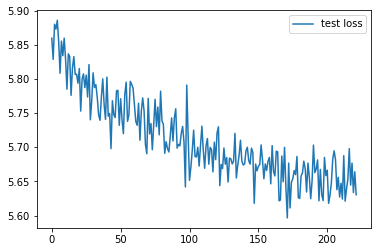

 55%|█████▌    | 2210/4000 [05:04<04:06,  7.25it/s]

Early stopped at 2210


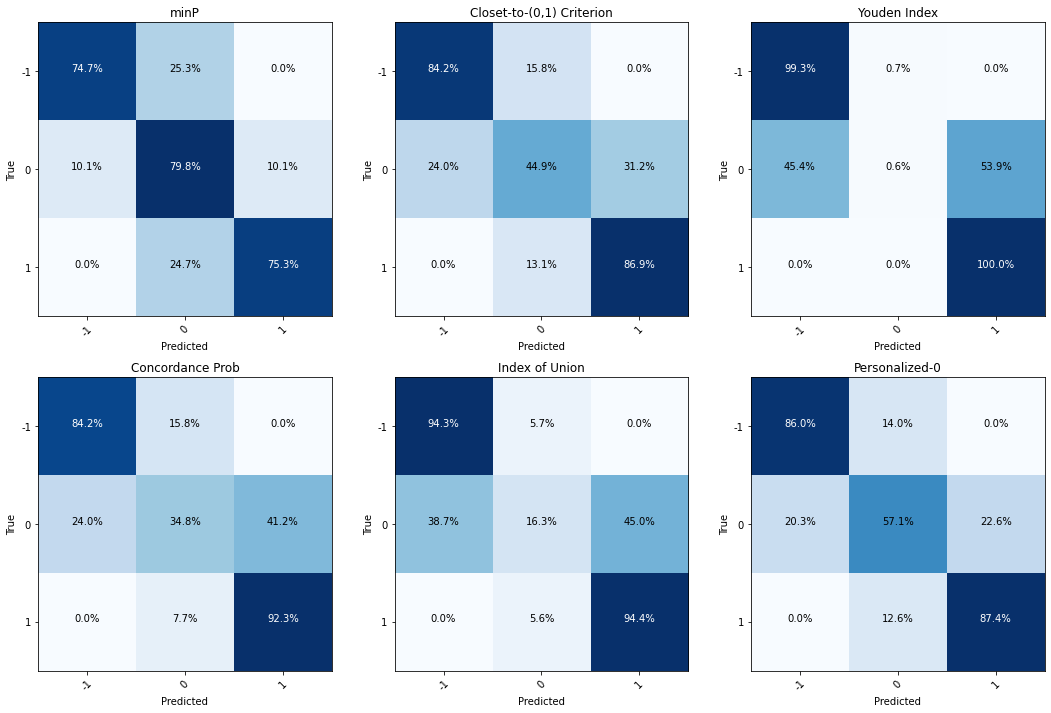

,Method,Cut0,RMSE0,Cut1,RMSE1,Acc,False alarm,Missing alarm,F1,HitT0 (8.07),HitT1 (8.59)
0,minP,0.20,0.18,0.80,0.18,0.77,0.15,0.15,0.85,14.44,14.55
1,"Closet-to-(0,1) Criterion",0.31,0.18,0.67,0.18,0.68,0.33,0.27,0.70,8.88,7.69
2,Youden Index,0.50,0.29,0.50,0.28,0.57,0.42,0.38,0.60,0.12,0.12
3,Concordance Prob,0.31,0.18,0.60,0.21,0.65,0.38,0.26,0.68,8.88,4.44
4,Index of Union,0.44,0.25,0.57,0.23,0.60,0.39,0.36,0.62,2.90,3.18
5,Personalized-0,0.29,0.15,0.71,0.14,0.74,0.26,0.24,0.75,9.63,9.62


In [42]:
CUDA = torch.cuda.is_available()
print(CUDA)

train_set = TensorDataset(torch.from_numpy(np.concatenate([X_train, np.ones([X_train.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_train.astype(np.float32)).unsqueeze(-1))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_set = TensorDataset(torch.from_numpy(np.concatenate([X_valid, np.ones([X_valid.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_valid.astype(np.float32)).unsqueeze(-1))
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_set = TensorDataset(torch.from_numpy(np.concatenate([X_test, np.ones([X_test.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_test.astype(np.float32)).unsqueeze(-1))
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

n_features = X_train.shape[1] + 1
epochs = 4000
w_pos = 1.8
w_zero = 0.5
w_neg = 1.4
c0 = 1.2

lr = 1e-4
model, val_loss = trainTwoThresholds(n_features, val_loader, test_loader, epochs, CUDA, c0, lr, w_pos, w_neg, w_zero)
test_y_score, test_y_true, cutoff0, cutoff1, theta_true = getEval(model, test_loader, CUDA)

y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1 = eval_cutoffs(cutoff0, cutoff1, test_y_true, test_y_score, theta_true)



results = pd.DataFrame(list(zip(methods + ['Personalized-0'], cutoff0s + [np.mean(cutoff0)], rmse0s + [rmse0],
                                cutoff1s + [np.mean(cutoff1)], rmse1s + [rmse1], accs + [acc], fars+ [far], 
                                mars + [mar], f1s + [f1], mht0s + [mht0], mht1s + [mht1])), columns=['Method','Cut0','RMSE0','Cut1','RMSE1','Acc','False alarm','Missing alarm','F1','HitT0 ({:.2f})'.format(mht0_true),'HitT1 ({:.2f})'.format(mht1_true)])

plt.figure(figsize=(15, 10))
for i in range(len(methods)):
    plt.subplot(2,3,i+1)
    plot_confusion_matrix_custom(cms[i],
                          target_names = [-1,0,1],
                          title=methods[i],
                          normalize=True)

i += 1
plt.subplot(2,3,i+1)
plot_confusion_matrix_custom(df_cm,
                      target_names = [-1,0,1],
                      title='Personalized-0',
                      normalize=True)
plt.tight_layout()  
plt.show()

results.round(2)


In [13]:
train_set = TensorDataset(torch.from_numpy(np.concatenate([X_train, np.ones([X_train.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_train.astype(np.float32)).unsqueeze(-1))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_set = TensorDataset(torch.from_numpy(np.concatenate([X_valid, np.ones([X_valid.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_valid.astype(np.float32)).unsqueeze(-1))
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_set = TensorDataset(torch.from_numpy(np.concatenate([X_test, np.ones([X_test.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_test.astype(np.float32)).unsqueeze(-1))
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

n_features = X_train.shape[1] + 1
epochs = 4000
w_pos = 1.8
w_zero = 0.5
w_neg = 1.4
c0 = 1.2

lr = 1e-4

w_poss = []
w_zeros = []
w_negs = []

p_accs = []
p_fars = []
p_mars = []
p_f1s = []
p_mht0s = []
p_mht1s = []
p_rmse0s = []
p_rmse1s = []

for w_pos in [1, 1.2, 1.4, 1.6, 1.8, 2]:
    for w_neg in [1, 1.2, 1.4, 1.6, 1.8, 2]:
        model, val_loss = trainTwoThresholds(n_features, val_loader, test_loader, epochs, CUDA, c0, lr, w_pos, w_neg, w_zero)
        test_y_score, test_y_true, cutoff0, cutoff1, theta_true = getEval(model, test_loader, CUDA)
        y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1 = eval_cutoffs(cutoff0, cutoff1, test_y_true, test_y_score, theta_true)

        w_poss.append(w_pos)
        w_negs.append(w_neg)

        p_accs.append(acc)
        p_fars.append(far)
        p_mars.append(mar)
        p_f1s.append(f1)
        p_mht0s.append(mht0)
        p_mht1s.append(mht1)
        p_rmse0s.append(rmse0)
        p_rmse1s.append(rmse1)

        
tune_results = pd.DataFrame(list(zip(w_poss, w_negs, p_rmse0s, p_rmse1s,
                                p_accs, p_fars, p_mars, p_f1s,
                               p_mht0s, p_mht1s)), columns=['w_pos','w_neg','RMSE0','RMSE1','Acc','False alarm','Missing alarm','F1','HitT0 ({:.2f})'.format(mht0_true),'HitT1 ({:.2f})'.format(mht1_true)])

tune_results.to_csv('sim_personlized_0_tuned.csv')
tune_results

,w_pos,w_neg,RMSE0,RMSE1,Acc,False alarm,Missing alarm,F1,HitT0 (8.07),HitT1 (8.59)
0,1.0,1.0,0.192052,0.223277,0.723167,0.000000,0.144044,0.922388,17.348315,21.459459
1,1.0,1.2,0.146931,0.228718,0.722500,0.000000,0.298814,0.824349,11.932584,21.729730
2,1.0,1.4,0.162914,0.236108,0.692000,0.000000,0.413978,0.738983,8.483146,21.891892
3,1.0,1.6,0.248747,0.245065,0.629167,0.000000,0.578354,0.593180,2.144444,22.954545
4,1.0,1.8,0.223231,0.254446,0.618000,0.000000,0.619850,0.550882,2.031496,23.561644
5,1.0,2.0,0.265157,0.224586,0.651833,0.000000,0.544780,0.625638,0.960317,20.581081
6,1.2,1.0,0.197277,0.187704,0.768667,0.055188,0.100210,0.921752,17.730337,17.513514
7,1.2,1.2,0.155627,0.172351,0.790500,0.084321,0.182353,0.863891,13.022472,16.216216
8,1.2,1.4,0.149201,0.193624,0.752500,0.021722,0.320670,0.801846,8.910112,18.630631
9,1.2,1.6,0.156295,0.209921,0.739500,0.013135,0.370039,0.769021,6.910112,19.468468


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


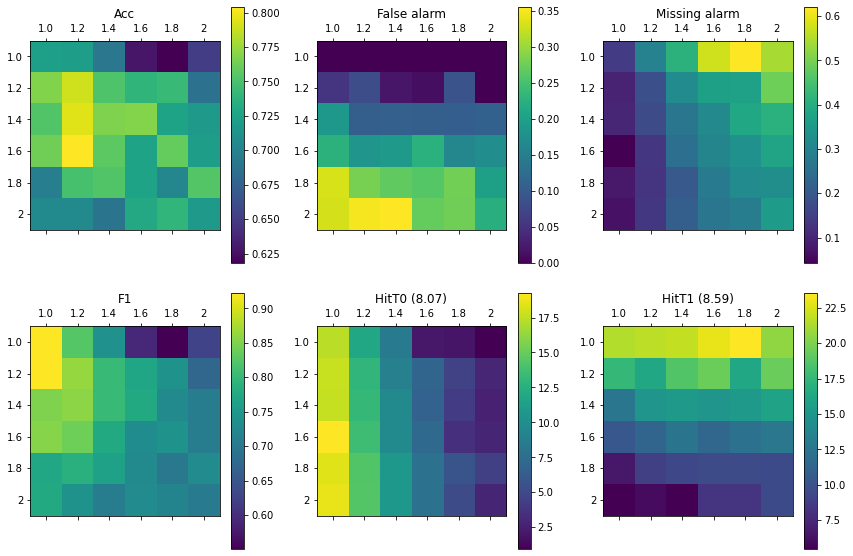

In [28]:
weights = [1.0, 1.2, 1.4, 1.6, 1.8, 2] 
  
names = tune_results.columns
metrics = np.array(names[4:])

figure = plt.figure(figsize=(12, 8))

for i in range(len(metrics)):
    metric = metrics[i]
    m_array = np.array(tune_results[metric]).reshape(6,6)
    axes = figure.add_subplot(2,3,i+1) 

    # using the matshow() function  
    caxes = axes.matshow(m_array, interpolation ='nearest') 
    figure.colorbar(caxes) 

    axes.set_xticklabels(['']+weights) 
    axes.set_yticklabels(['']+weights) 
#     axes.set_xlabel('w_{-1}')
#     axes.set_ylabel('w_1')
    axes.set_title(metric)
    
plt.tight_layout()  
plt.show()

### 4.2 L1

In [32]:
from scipy.special import logit, expit
# Fit expected hitting time

def gen_thresholds_P(scores, n = 50):
    min_score = logit(max(np.min(scores), 0.001))
    max_score = logit(min(np.max(scores), 0.999))

    thresholds = [expit(x) for x in np.linspace(min_score, max_score, n)]
    return np.array(thresholds)

def gen_thresholds_R(ratio, n = 50):
    min_score = np.min(ratio)
    max_score = np.max(ratio)
    
    return np.linspace(min_score, max_score, n)

def gen_hitting_time_data(x_demo, scores, prob=True):
    if prob:
        thresholds = gen_thresholds_P(scores)
    else:
        thresholds = gen_thresholds_R(scores)
     
    # d = 1
    x_1 = []
    res_1 = []
    T_1 = []
    p_1 = []
    
    # d = 0
    x_0 = []
    res_0 = []
    T_0 = []
    p_0 = []
    
    for theta in thresholds:
        for i in range(scores.shape[0]):
            over_theta = scores[i,:] > theta
            below_theta = scores[i,:] < theta
            equal_theta = scores[i,:] == theta
            
            for j in range(scores.shape[1]):
                if over_theta[j] == True:
                    idx = np.argmax(equal_theta[j:])
                    if idx > 0:
                        x_0.append(x_demo[i])
                        res_0.append(scores[i,j] - theta)
                        T_0.append(j+idx)
                        p_0.append(scores[i,j])
                    else:
                        idx = np.argmax(below_theta[j:])
                        if idx > 0:
                            x_0.append(x_demo[i])
                            res_0.append(scores[i,j] - theta)
                            T_0.append(j+idx)
                            p_0.append(scores[i,j])
                        
                if below_theta[j] == True:
                    idx = np.argmax(equal_theta[j:])
                    if idx > 0:
                        x_1.append(x_demo[i])
                        res_1.append(theta - scores[i,j])
                        T_1.append(j+idx)
                        p_1.append(scores[i,j])
                    else:
                        idx = np.argmax(over_theta[j:])
                        if idx > 0:
                            x_1.append(x_demo[i])
                            res_1.append(theta - scores[i,j])
                            T_1.append(j+idx)
                            p_1.append(scores[i,j])
                            
    return np.array(x_0), np.array(res_0).reshape(-1,1), np.array(p_0).reshape(-1,1),np.array(T_0).reshape(-1,1), np.array(x_1), np.array(res_1).reshape(-1,1),np.array(p_1).reshape(-1,1), np.array(T_1).reshape(-1,1)

train_x_0, train_res_0, train_p_0, train_T_0, train_x_1, train_res_1, train_p_1, train_T_1 = gen_hitting_time_data(X_train, P_train, prob=True)
val_x_0, val_res_0, val_p_0, val_T_0, val_x_1, val_res_1, val_p_1, val_T_1 = gen_hitting_time_data(X_valid, P_valid, prob=True)
test_x_0, test_res_0, test_p_0, test_T_0, test_x_1, test_res_1,test_p_1, test_T_1 = gen_hitting_time_data(X_test, P_test, prob=True)
print(val_x_0.shape, val_res_0.shape, val_p_0.shape,val_T_0.shape)

(20765, 2) (20765, 1) (20765, 1) (20765, 1)


In [35]:
class Neg_Log_Exp_Loss(nn.Module):
    def __init__(self):
        super(Neg_Log_Exp_Loss,self).__init__()

    def forward(self, rate, t):
        loss =  - torch.mean(torch.log(rate)- rate * t)
        return loss
    
class T_MLPNet(nn.Module):
    def __init__(self, n_features):
        super(T_MLPNet,self).__init__()
        self.n_features = n_features

        self.layer0 = nn.Sequential(
            nn.Linear(n_features, 1),
            nn.ReLU()
        )

    def forward(self, u, res, p):
        rate = self.layer0(torch.cat([u,res, p],-1)) + 0.00001
        return rate
    
def train_T(n_features, val_loader, test_loader, epochs, CUDA):
    model = T_MLPNet(n_features)
    best_model = model
    best_val_loss = 9999
    n_no_decreasing = 0
    n_early_stop = 50
    if CUDA:
        with torch.cuda.device(device):
            model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

    criterion = Neg_Log_Exp_Loss()
    train_loss = []
    val_loss = []
    for epoch in tqdm(range(epochs)):
        e_train_loss = 0
        model.train()
        for i, batch in enumerate(val_loader):
            x_demo, res, p, t = Variable(batch[0]), Variable(batch[1]), Variable(batch[2]), Variable(batch[3])

            if CUDA:
                with torch.cuda.device(device):
                    x_demo = x_demo.cuda()
                    res = res.cuda()
                    t = t.cuda()
                    p = p.cuda()

            optimizer.zero_grad()
            rate = model(x_demo, res,p)
            
            loss = criterion(rate, t)
            loss.backward()
            optimizer.step()
            e_train_loss += loss.data.cpu()
        train_loss.append(e_train_loss/i)

        e_val_loss = 0
        model.eval()
        for i, batch in enumerate(test_loader):
            x_demo, res, p, t = Variable(batch[0]), Variable(batch[1]), Variable(batch[2]), Variable(batch[3])

            if CUDA:
                with torch.cuda.device(device):
                    x_demo = x_demo.cuda()
                    res = res.cuda()
                    t = t.cuda()
                    p = p.cuda()
                
            rate = model(x_demo, res,p)
            
            loss = criterion(rate, t)
            e_val_loss += loss.data.cpu()

        #scheduler.step(e_val_loss/i)   
        val_loss.append(e_val_loss/i)  
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_model = model
            n_no_decreasing = 0
        else:
            n_no_decreasing += 1

        if n_no_decreasing >= n_early_stop:
            plt.plot(val_loss, label='test loss')
            plt.legend()
            plt.show()
            print('Early stopped at {}'.format(epoch))
            return best_model, val_loss

    #plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()
    plt.show()
    return best_model, val_loss

def evaluate_T(model, test_loader, CUDA):
    model.eval()
    obs_t = []
    pred_t = []
    for i, batch in enumerate(test_loader):
        x_demo, res, p, t = Variable(batch[0]), Variable(batch[1]), Variable(batch[2]), Variable(batch[3])

        if CUDA:
            with torch.cuda.device(device):
                x_demo = x_demo.cuda()
                res = res.cuda()
                p = p.cuda()

        rate = model(x_demo, res,p)
        
        obs_t.extend(t.reshape(-1).data.numpy().tolist())
        pred_t.extend(rate.reshape(-1).data.cpu().numpy().tolist())
        
            
    obs_t = np.array(obs_t)
    pred_t = np.array(pred_t)
    
#     return np.sqrt(np.mean((obs_t - 1/pred_t) *(obs_t - 1/pred_t) ))
    return np.mean(obs_t) - np.mean(1/pred_t)

  0%|          | 0/200 [00:00<?, ?it/s]

True


 50%|█████     | 101/200 [04:09<04:08,  2.51s/it]

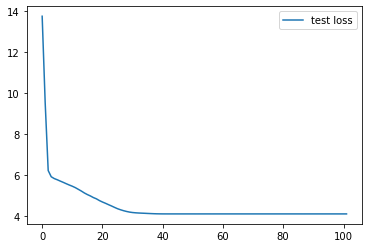

 50%|█████     | 101/200 [04:12<04:07,  2.50s/it]

Early stopped at 101



  0%|          | 0/200 [00:00<?, ?it/s]

0.030659530420660275 0.20035972638221722


 35%|███▌      | 70/200 [03:06<05:46,  2.67s/it]

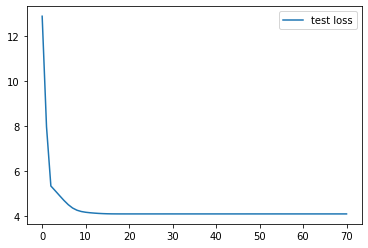

 35%|███▌      | 70/200 [03:09<05:52,  2.71s/it]

Early stopped at 70


-0.10598414635483522 -0.1848863458101313


In [36]:
CUDA = torch.cuda.is_available()
print(CUDA)

val_set = TensorDataset(torch.from_numpy(np.concatenate([train_x_0, np.ones([train_x_0.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(train_res_0.astype(np.float32)), torch.from_numpy(train_p_0.astype(np.float32)), torch.from_numpy(train_T_0.astype(np.float32)))
val_loader0 = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_set = TensorDataset(torch.from_numpy(np.concatenate([test_x_0, np.ones([test_x_0.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(test_res_0.astype(np.float32)), torch.from_numpy(test_p_0.astype(np.float32)), torch.from_numpy(test_T_0.astype(np.float32)))
test_loader0 = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

n_features = test_x_0.shape[1] + 3
epochs = 200

model0,val_loss = train_T(n_features, val_loader0, test_loader0, epochs, CUDA)

rmse_val0 = evaluate_T(model0, val_loader0, CUDA)
rmse_test0 = evaluate_T(model0, test_loader0, CUDA)
print(rmse_val0, rmse_test0)

val_set = TensorDataset(torch.from_numpy(np.concatenate([train_x_1, np.ones([train_x_1.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(train_res_1.astype(np.float32)), torch.from_numpy(train_p_1.astype(np.float32)), torch.from_numpy(train_T_1.astype(np.float32)))
val_loader1 = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_set = TensorDataset(torch.from_numpy(np.concatenate([test_x_1, np.ones([test_x_1.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(test_res_1.astype(np.float32)), torch.from_numpy(test_p_1.astype(np.float32)), torch.from_numpy(test_T_1.astype(np.float32)))
test_loader1 = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

n_features = test_x_1.shape[1] + 3
epochs = 200

model1,val_loss  = train_T(n_features, val_loader1, test_loader1, epochs, CUDA)

rmse_val1 = evaluate_T(model1, val_loader1, CUDA)
rmse_test1 = evaluate_T(model1, test_loader1, CUDA)
print(rmse_val1, rmse_test1)

In [37]:
class L1(nn.Module):
    def __init__(self, predT0, predT1):
        super(L1,self).__init__()
        self.predT0 = predT0
        self.predT1 = predT1

    def forward(self, x_demo, p, theta0, theta1, c1):
        theta0 = theta0.unsqueeze(1).repeat(1,p.shape[1],1)
        theta1 = theta1.unsqueeze(1).repeat(1,p.shape[1],1)
        x_demo = x_demo.unsqueeze(1).repeat(1,p.shape[1],1)
        
#         indices = (theta0 < p < theta1) * 1
        pred0 = (p <= theta0) * (-1)
        pred1 = (p >= theta1) * 1
        
        pred = (pred0 + pred1).float()
        pred = (1-pred) * (1+pred) # only zero left
        
        if torch.sum(pred) > 0:
            T0 = self.predT0(x_demo, torch.abs(p - theta0), p)
            T0 = 1/T0
            
            T1 = self.predT1(x_demo, torch.abs(theta1 - p), p)
            T1 = 1/T1
            
            loss = c1 * torch.sum((T0 + T1)*pred)/torch.sum(pred)
        else:
            loss = 0
        return loss

  0%|          | 0/4000 [00:00<?, ?it/s]

True
5909 7748 5543


 26%|██▌       | 1030/4000 [02:28<06:39,  7.43it/s]

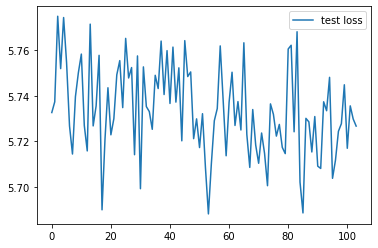

 26%|██▌       | 1030/4000 [02:29<07:10,  6.90it/s]

Early stopped at 1030


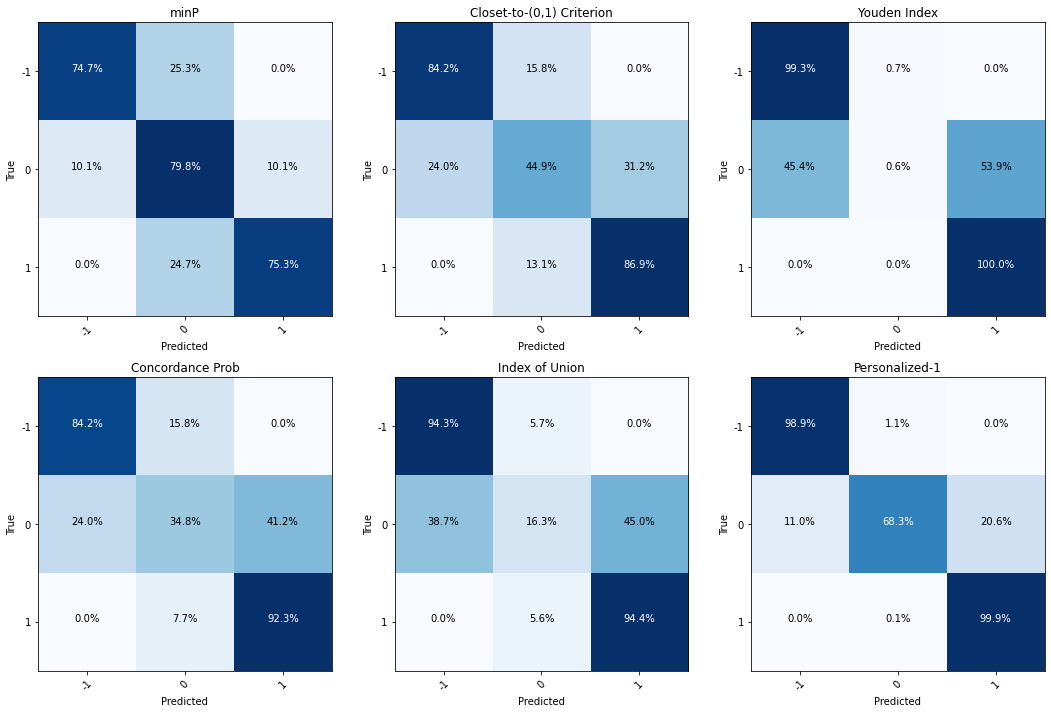

,Method,Cut0,RMSE0,Cut1,RMSE1,Acc,False alarm,Missing alarm,F1,HitT0 (8.07),HitT1 (8.59)
0,minP,0.20,0.18,0.80,0.18,0.77,0.15,0.15,0.85,14.44,14.55
1,"Closet-to-(0,1) Criterion",0.31,0.18,0.67,0.18,0.68,0.33,0.27,0.70,8.88,7.69
2,Youden Index,0.50,0.29,0.50,0.28,0.57,0.42,0.38,0.60,0.12,0.12
3,Concordance Prob,0.31,0.18,0.60,0.21,0.65,0.38,0.26,0.68,8.88,4.44
4,Index of Union,0.44,0.25,0.57,0.23,0.60,0.39,0.36,0.62,2.90,3.18
5,Personalized-1,0.31,0.06,0.65,0.09,0.86,0.22,0.13,0.82,5.59,5.22


In [41]:
CUDA = torch.cuda.is_available()
print(CUDA)

model0.to(device)
model1.to(device)

train_set = TensorDataset(torch.from_numpy(np.concatenate([X_train, np.ones([X_train.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_train.astype(np.float32)).unsqueeze(-1))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_set = TensorDataset(torch.from_numpy(np.concatenate([X_valid, np.ones([X_valid.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_valid.astype(np.float32)).unsqueeze(-1))
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_set = TensorDataset(torch.from_numpy(np.concatenate([X_test, np.ones([X_test.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_test.astype(np.float32)).unsqueeze(-1))
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

n_features = X_train.shape[1] + 1
epochs = 4000
w_pos = 1.8
w_zero = 0.5
w_neg = 1.4
c0 = 1.2
c1 = 0.004


print(np.sum(Y_train == 1), np.sum(Y_train == 0), np.sum(Y_train == -1))

lr = 1e-4
model, val_loss = trainTwoThresholds(n_features, val_loader, test_loader, epochs, CUDA, c0, lr, w_pos, w_neg, w_zero, c1, model)
test_y_score, test_y_true, cutoff0, cutoff1, theta_true = getEval(model, test_loader, CUDA)
y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1 = eval_cutoffs(cutoff0, cutoff1, test_y_true, test_y_score, theta_true)


results = pd.DataFrame(list(zip(methods + ['Personalized-1'], cutoff0s + [np.mean(cutoff0)], rmse0s + [rmse0],
                                cutoff1s + [np.mean(cutoff1)], rmse1s + [rmse1], accs + [acc], fars+ [far], 
                                mars + [mar], f1s + [f1], mht0s + [mht0], mht1s + [mht1])), columns=['Method','Cut0','RMSE0','Cut1','RMSE1','Acc','False alarm','Missing alarm','F1','HitT0 ({:.2f})'.format(mht0_true),'HitT1 ({:.2f})'.format(mht1_true)])

plt.figure(figsize=(15, 10))
for i in range(len(methods)):
    plt.subplot(2,3,i+1)
    plot_confusion_matrix_custom(cms[i],
                          target_names = [-1,0,1],
                          title=methods[i],
                          normalize=True)

    
i += 1
plt.subplot(2,3,i+1)
plot_confusion_matrix_custom(df_cm,
                      target_names = [-1,0,1],
                      title='Personalized-1',
                      normalize=True)
plt.tight_layout()  
plt.show()

results.round(2)

 22%|██▏       | 890/4000 [02:08<07:01,  7.38it/s]

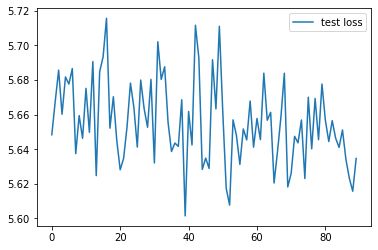

 22%|██▏       | 890/4000 [02:09<07:31,  6.88it/s]

Early stopped at 890



 89%|████████▉ | 3570/4000 [08:47<00:57,  7.45it/s]

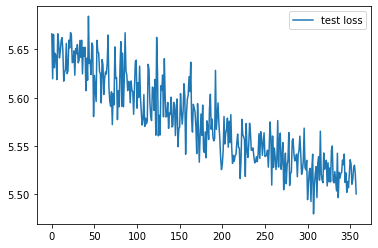

 89%|████████▉ | 3570/4000 [08:47<01:03,  6.77it/s]

Early stopped at 3570



 38%|███▊      | 1520/4000 [03:43<05:33,  7.44it/s]

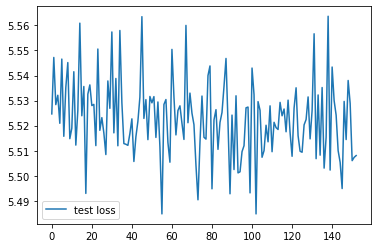

 38%|███▊      | 1520/4000 [03:43<06:04,  6.80it/s]

Early stopped at 1520



 40%|████      | 1600/4000 [03:59<05:57,  6.71it/s]

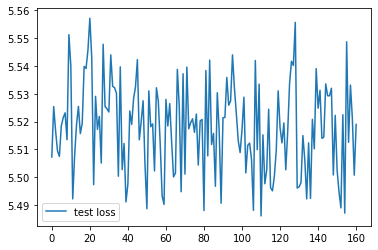

 40%|████      | 1600/4000 [04:00<06:00,  6.66it/s]

Early stopped at 1600



 18%|█▊        | 700/4000 [01:48<07:53,  6.97it/s]

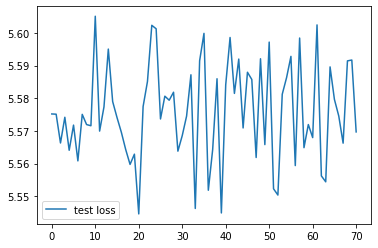

 18%|█▊        | 700/4000 [01:49<08:34,  6.41it/s]

Early stopped at 700



 23%|██▎       | 920/4000 [02:22<07:17,  7.04it/s]

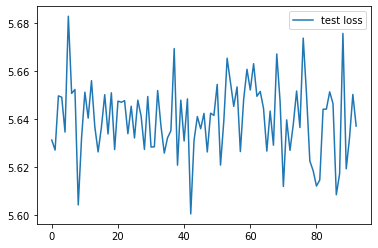

 23%|██▎       | 920/4000 [02:22<07:58,  6.44it/s]

Early stopped at 920



 21%|██▏       | 850/4000 [02:11<07:35,  6.92it/s]

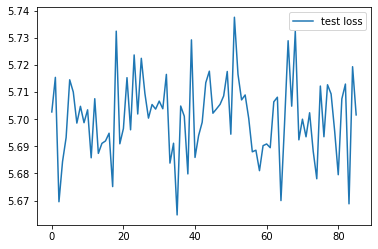

 21%|██▏       | 850/4000 [02:11<08:09,  6.44it/s]

Early stopped at 850



 25%|██▍       | 990/4000 [03:10<07:18,  6.86it/s]

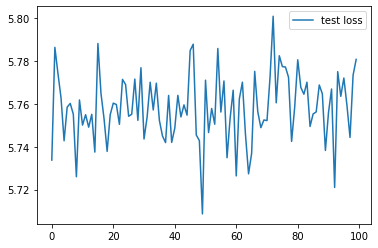

 25%|██▍       | 990/4000 [03:10<09:39,  5.19it/s]

Early stopped at 990



 20%|██        | 810/4000 [02:05<08:03,  6.60it/s]

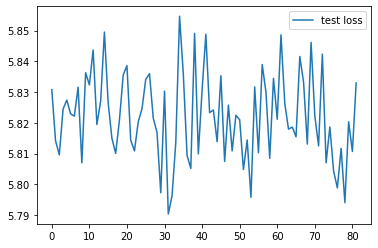

 20%|██        | 810/4000 [02:05<08:15,  6.43it/s]

Early stopped at 810



 53%|█████▎    | 2120/4000 [05:23<04:30,  6.94it/s]

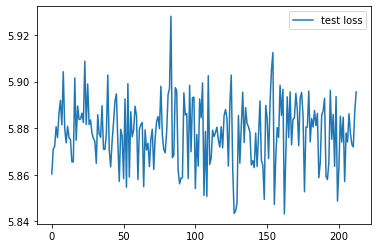

 53%|█████▎    | 2120/4000 [05:24<04:47,  6.54it/s]

Early stopped at 2120



 30%|███       | 1220/4000 [02:59<06:28,  7.15it/s]

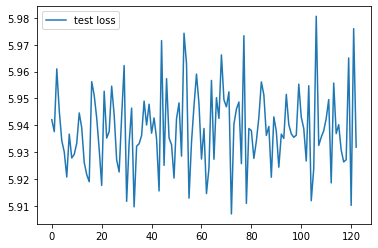

 30%|███       | 1220/4000 [02:59<06:49,  6.80it/s]

Early stopped at 1220



 18%|█▊        | 710/4000 [01:45<07:23,  7.42it/s]

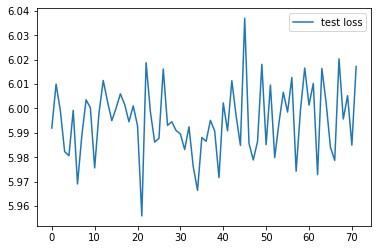

 18%|█▊        | 710/4000 [01:46<08:12,  6.68it/s]

Early stopped at 710



 14%|█▎        | 540/4000 [01:20<07:58,  7.23it/s]

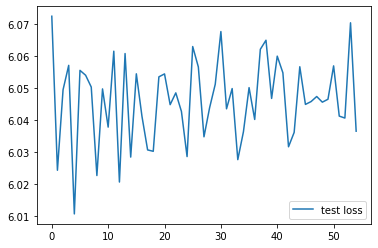

 14%|█▎        | 540/4000 [01:20<08:38,  6.68it/s]

Early stopped at 540


,c1,RMSE0,RMSE1,Acc,False alarm,Missing alarm,F1,HitT0 (8.07),HitT1 (8.59)
0,0.0005,0.127554,0.130909,0.757833,0.255206,0.214486,0.764612,10.168539,9.585586
1,0.0007,0.033275,0.065787,0.910667,0.160407,0.076325,0.879630,7.307692,6.165138
2,0.0009,0.025463,0.068011,0.914000,0.172952,0.057778,0.880886,4.045455,3.535714
3,0.0010,0.025937,0.067370,0.915000,0.171875,0.056380,0.882108,3.977528,3.414414
4,0.0020,0.038018,0.074336,0.897000,0.187047,0.085769,0.860622,3.644444,3.145455
5,0.0030,0.047846,0.083799,0.872833,0.211244,0.116667,0.833370,3.377778,2.872727
6,0.0040,0.053844,0.089283,0.863833,0.219632,0.127971,0.823656,3.300000,2.827273
7,0.0050,0.064064,0.092579,0.849167,0.228155,0.151623,0.808303,3.066667,2.763636
8,0.0060,0.070113,0.104146,0.833667,0.246148,0.164258,0.792688,2.911111,2.563636
9,0.0070,0.080070,0.111181,0.815500,0.261610,0.184267,0.775137,2.711111,2.481818


In [44]:
train_set = TensorDataset(torch.from_numpy(np.concatenate([X_train, np.ones([X_train.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_train.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_train.astype(np.float32)).unsqueeze(-1))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_set = TensorDataset(torch.from_numpy(np.concatenate([X_valid, np.ones([X_valid.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_valid.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_valid.astype(np.float32)).unsqueeze(-1))
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_set = TensorDataset(torch.from_numpy(np.concatenate([X_test, np.ones([X_test.shape[0],1])], -1).astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(P_test.astype(np.float32)).unsqueeze(-1), torch.from_numpy(Theta_test.astype(np.float32)).unsqueeze(-1))
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

n_features = X_train.shape[1] + 1
epochs = 4000
w_pos = 1.8
w_zero = 0.5
w_neg = 1.4
c0 = 1.2

lr = 1e-4

c1s = []

p_accs = []
p_fars = []
p_mars = []
p_f1s = []
p_mht0s = []
p_mht1s = []
p_rmse0s = []
p_rmse1s = []

for c1 in [0.0005, 0.0007, 0.0009, 0.001,0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,0.01]:
    model, val_loss = trainTwoThresholds(n_features, val_loader, test_loader, epochs, CUDA, c0, lr, w_pos, w_neg, w_zero, c1, model)
    test_y_score, test_y_true, cutoff0, cutoff1, theta_true = getEval(model, test_loader, CUDA)
    y_pred, y_true, acc, far, mar, f1, df_cm, mht0, mht1, mht0_true, mht1_true, rmse0, rmse1 = eval_cutoffs(cutoff0, cutoff1, test_y_true, test_y_score, theta_true)

    c1s.append(c1)

    p_accs.append(acc)
    p_fars.append(far)
    p_mars.append(mar)
    p_f1s.append(f1)
    p_mht0s.append(mht0)
    p_mht1s.append(mht1)
    p_rmse0s.append(rmse0)
    p_rmse1s.append(rmse1)

        
tune_results = pd.DataFrame(list(zip(c1s, p_rmse0s, p_rmse1s,
                                p_accs, p_fars, p_mars, p_f1s,
                               p_mht0s, p_mht1s)), columns=['c1','RMSE0','RMSE1','Acc','False alarm','Missing alarm','F1','HitT0 ({:.2f})'.format(mht0_true),'HitT1 ({:.2f})'.format(mht1_true)])

tune_results.to_csv('sim_personlized_1_tuned.csv')
tune_results

In [45]:
tune_results = pd.DataFrame(list(zip(c1s, p_rmse0s, p_rmse1s,
                                p_accs, p_fars, p_mars, p_f1s,
                               p_mht0s, p_mht1s)), columns=['c1','RMSE0','RMSE1','Acc','False alarm','Missing alarm','F1','HitT0 ({:.2f})'.format(mht0_true),'HitT1 ({:.2f})'.format(mht1_true)])

tune_results.to_csv('sim_personlized_1_tuned.csv')
tune_results

,c1,RMSE0,RMSE1,Acc,False alarm,Missing alarm,F1,HitT0 (8.07),HitT1 (8.59)
0,0.0005,0.127554,0.130909,0.757833,0.255206,0.214486,0.764612,10.168539,9.585586
1,0.0007,0.033275,0.065787,0.910667,0.160407,0.076325,0.879630,7.307692,6.165138
2,0.0009,0.025463,0.068011,0.914000,0.172952,0.057778,0.880886,4.045455,3.535714
3,0.0010,0.025937,0.067370,0.915000,0.171875,0.056380,0.882108,3.977528,3.414414
4,0.0020,0.038018,0.074336,0.897000,0.187047,0.085769,0.860622,3.644444,3.145455
5,0.0030,0.047846,0.083799,0.872833,0.211244,0.116667,0.833370,3.377778,2.872727
6,0.0040,0.053844,0.089283,0.863833,0.219632,0.127971,0.823656,3.300000,2.827273
7,0.0050,0.064064,0.092579,0.849167,0.228155,0.151623,0.808303,3.066667,2.763636
8,0.0060,0.070113,0.104146,0.833667,0.246148,0.164258,0.792688,2.911111,2.563636
9,0.0070,0.080070,0.111181,0.815500,0.261610,0.184267,0.775137,2.711111,2.481818


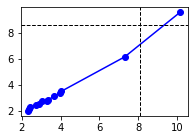

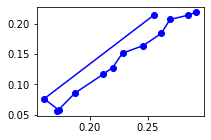

In [65]:
plt.figure(figsize=(3,2))
plt.plot(tune_results['HitT0 (8.07)'],tune_results['HitT1 (8.59)'], 'bo-',lw=1.5)
plt.axhline(y=8.59,color='k',linewidth=1,linestyle='--')
plt.axvline(x=8.07,color='k',linewidth=1,linestyle='--')
plt.show()

plt.figure(figsize=(3,2))
plt.plot(tune_results['False alarm'],tune_results['Missing alarm'], 'bo-',lw=1.5)
plt.show()
